In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

import jax
import jax.numpy as jnp
import numpy as onp

import haiku as hk
from jax.experimental import optix

from nsec.datasets.two_moons import get_two_moons
from nsec.utils import display_score_two_moons
from nsec.models.dae.ardae import ARDAE
from nsec.normalization import SNParamsTree as CustomSNParamsTree

from functools import partial

Populating the interactive namespace from numpy and matplotlib


##  Defining the analytic target distribution

/Users/br263581/opt/anaconda3/envs/cosmo/lib/python3.7/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


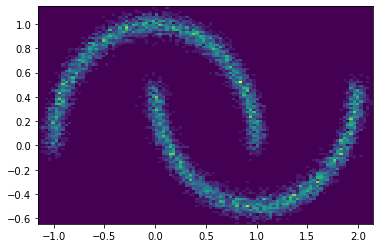

In [3]:
two_moons = get_two_moons(0.05)

rng_key = jax.random.PRNGKey(seed=0)
samps = two_moons.sample(10000, seed=rng_key)

# Plotting samples
hist2d(samps[:,0], samps[:,1],100);

In [4]:
# But now we can also compute the gradients of log p :-)
true_score = jax.vmap(jax.grad(two_moons.log_prob))

/Users/br263581/opt/anaconda3/envs/cosmo/lib/python3.7/site-packages/jax/numpy/lax_numpy.py:1601: FutureWarning: jax.numpy reductions won't accept lists and tuples in future versions, only scalars and ndarrays
  warnings.warn(msg, category=FutureWarning)


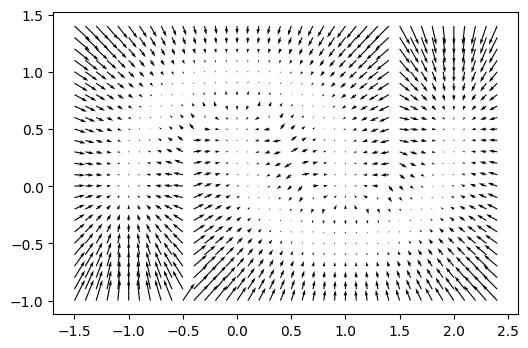

In [5]:
# Close up
figure(dpi=100)
X = np.arange(-1.5, 2.5, 0.1)
Y = np.arange(-1, 1.5, 0.1)
points = stack(meshgrid(X, Y), axis=-1).reshape((-1, 2))
g = true_score(points).reshape([len(Y), len(X),2])

quiver(X, Y, g[:,:,0], g[:,:,1])

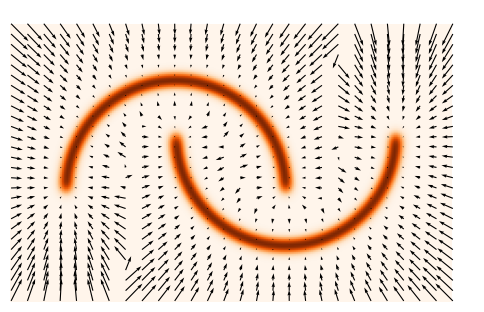

In [6]:
display_score_two_moons(true_score, two_moons, is_amortized=False, is_reg=False)

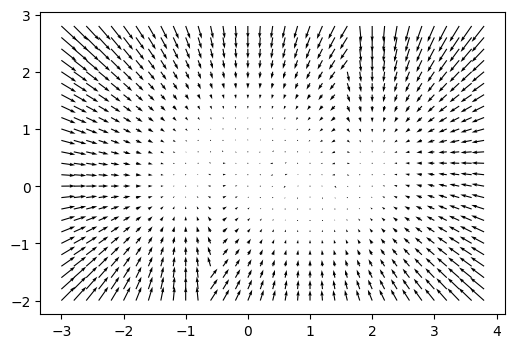

In [7]:
# Large scale
figure(dpi=100)
X = np.arange(-3, 4, 0.2)
Y = np.arange(-2, 3, 0.2)
points = stack(meshgrid(X, Y), axis=-1).reshape((-1, 2))
g = true_score(points).reshape([len(Y), len(X),2])

quiver(X, Y, g[:,:,0], g[:,:,1])

## Implementing AR-DAE 

```
class ARDAE(hk.Module):
    def __init__(self, is_training=False):
        super(ARDAE, self).__init__()
        self.is_training=is_training

    def __call__(self, x, sigma):
        sigma = sigma.reshape((-1,1))
        # Encoder
        net = hk.Linear(128)(jnp.concatenate([x, sigma],axis=1))
        net = hk.BatchNorm(True, True, 0.9)(net, self.is_training)
        net = jax.nn.leaky_relu(net)
        net = hk.Linear(128)(net)
        net = hk.BatchNorm(True, True, 0.9)(net, self.is_training)
        net = jax.nn.leaky_relu(net)
        net = hk.Linear(2)(net)

        # Decoder
        net = hk.Linear(128)(jnp.concatenate([net, sigma],axis=1))
        net = hk.BatchNorm(True, True, 0.9)(net, self.is_training)
        net = jax.nn.leaky_relu(net)
        net = hk.Linear(128)(net)
        net = hk.BatchNorm(True, True, 0.9)(net, self.is_training)
        net = jax.nn.leaky_relu(net)
        net = hk.Linear(2)(net)

        return net
```

In [8]:
def forward(x, sigma, is_training=False):
    denoiser = ARDAE(is_training=is_training)
    return denoiser(x, sigma)

model_train = hk.transform_with_state(partial(forward, is_training=True))


In [9]:
batch_size = 512
delta = 0.05

def get_batch(rng_key):
    y = two_moons.sample(batch_size, seed=rng_key)
    u = onp.random.randn(batch_size, 2)
    s = delta * onp.random.randn(batch_size, 1)
    x = y + s * u
    # x is a noisy sample, y is a sample from the distribution
    # u is the random normal noise realisation
    return {'x':x, 'y':y, 'u':u, 's':s}

In [10]:
optimizer = optix.adam(1e-3)
rng_seq = hk.PRNGSequence(42)

In [11]:
@jax.jit
def loss_fn(params, state, rng_key, batch):
    res, state = model_train.apply(params,  state, rng_key, 
                                   batch['x'], batch['s'])
    loss = jnp.mean((batch['u'] + batch['s'] * res)**2)
    return loss, state

In [12]:
@jax.jit
def update(params, state, rng_key, opt_state, batch):
    (loss, state), grads = jax.value_and_grad(loss_fn, has_aux=True)(params, state, rng_key, batch)
    updates, new_opt_state = optimizer.update(grads, opt_state)
    new_params = optix.apply_updates(params, updates)
    return loss, new_params, state, new_opt_state

In [13]:
params, state = model_train.init(next(rng_seq), 
                                 jnp.zeros((1, 2)), 
                                 jnp.ones((1, 1)))
opt_state = optimizer.init(params)
losses = []

In [14]:
for step in range(2000):
    batch = get_batch(next(rng_seq))
    loss, params, state, opt_state = update(params, state, next(rng_seq), opt_state, batch)
    losses.append(loss)
    if step%100==0:
        print(step, loss)

0 0.9884267
100 0.90840256
200 0.87324834
300 0.8453461
400 0.81687367
500 0.85322547
600 0.9148007
700 0.82285184
800 0.87035286
900 0.8650275
1000 0.9034761
1100 0.80154395
1200 0.8668951
1300 0.7947031
1400 0.85520065
1500 0.8262335
1600 0.87158185
1700 0.8460165
1800 0.7875946
1900 0.87349653


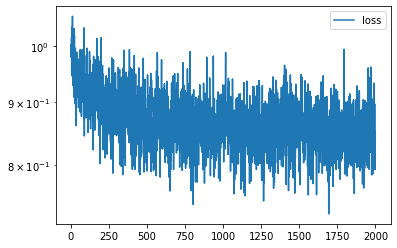

In [15]:
semilogy(np.array(losses[:]), label='loss')
legend()

In [16]:
X = np.arange(-1.5, 2.5, 0.1)
Y = np.arange(-1, 1.5, 0.1)
points = stack(meshgrid(X, Y), axis=-1).reshape((-1, 2))

model = hk.transform_with_state(partial(forward, is_training=False))
dae_score = partial(model.apply, params, state, next(rng_seq))

In [17]:
res, state = dae_score(points, 0.0*jnp.ones((len(points),1)))

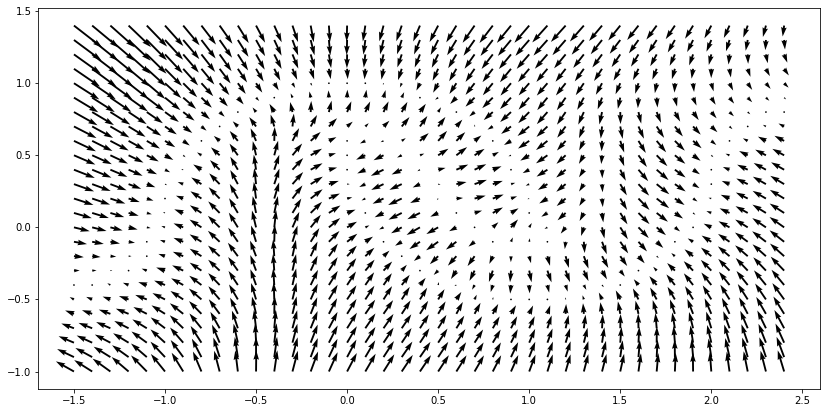

In [18]:
g = res.reshape([len(Y), len(X),2])
figure(figsize=(14,7))
quiver(X, Y, g[:,:,0], g[:,:,1])

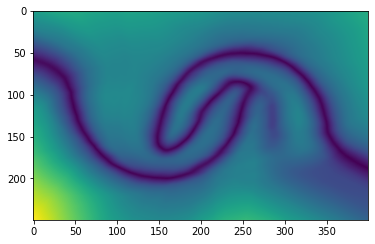

In [19]:
X = np.arange(-1.5, 2.5, 0.01)
Y = np.arange(-1, 1.5, 0.01)
points = stack(meshgrid(X, Y), axis=-1).reshape((-1, 2))
res, state = dae_score(points, jnp.zeros((len(points),1)))
g = res.reshape([len(Y), len(X),2])
imshow(np.sqrt(g[:,:,0]**2 + g[:,:,1]**2))

/Users/br263581/opt/anaconda3/envs/cosmo/lib/python3.7/site-packages/jax/numpy/lax_numpy.py:1601: FutureWarning: jax.numpy reductions won't accept lists and tuples in future versions, only scalars and ndarrays
  warnings.warn(msg, category=FutureWarning)


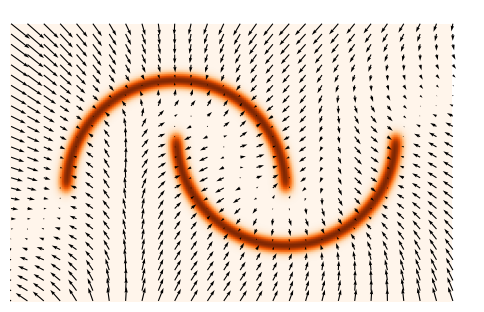

In [20]:
display_score_two_moons(dae_score, two_moons, is_amortized=True, is_reg=True)

In [21]:
X = np.arange(-3, 4, 0.2)
Y = np.arange(-2, 3, 0.2)
points = stack(meshgrid(X, Y), axis=-1).reshape((-1, 2))

res, state = dae_score(points, 0.0*jnp.ones((len(points),1)))

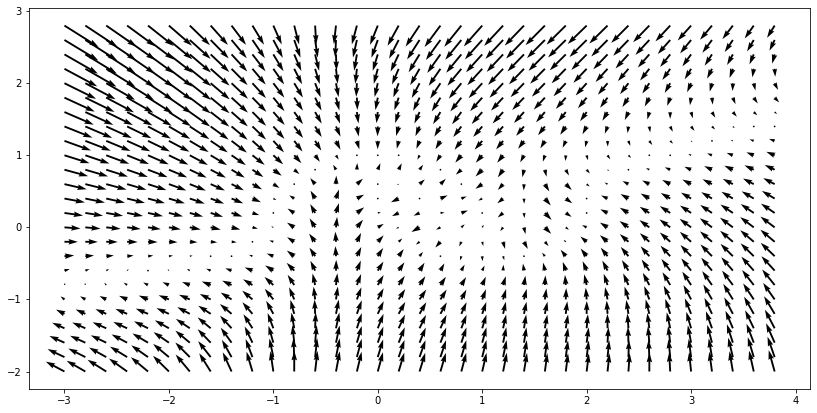

In [22]:
g = res.reshape([len(Y), len(X),2])
figure(figsize=(14,7))
quiver(X, Y, g[:,:,0], g[:,:,1])

## Adding Lipschitz regularisation

In [23]:
def forward(x, sigma, is_training=False):
    denoiser = ARDAE(is_training=is_training)
    return denoiser(x, sigma)

model_train = hk.transform_with_state(partial(forward, is_training=True))

sn_fn = hk.transform_with_state(lambda x: CustomSNParamsTree(ignore_regex='[^?!.]*b$')(x))

In [24]:
batch_size = 512
delta = 0.05

def get_batch(rng_key):
    y = two_moons.sample(batch_size, seed=rng_key)
    u = onp.random.randn(batch_size, 2)
    s = delta * onp.random.randn(batch_size, 1)
    x = y + s * u
    # x is a noisy sample, y is a sample from the distribution
    # u is the random normal noise realisation
    return {'x':x, 'y':y, 'u':u, 's':s}

In [25]:
optimizer = optix.adam(1e-3)
rng_seq = hk.PRNGSequence(42)

In [26]:
@jax.jit
def loss_fn(params, state, rng_key, batch):
    res, state = model_train.apply(params,  state, rng_key, 
                                   batch['x'], batch['s'])
    loss = jnp.mean((batch['u'] + batch['s'] * res)**2)
    return loss, state

In [27]:
@jax.jit
def update(params, state, sn_state, rng_key, opt_state, batch):
    (loss, state), grads = jax.value_and_grad(loss_fn, has_aux=True)(params, state, rng_key, batch)
    updates, new_opt_state = optimizer.update(grads, opt_state)
    new_params = optix.apply_updates(params, updates)
    
    new_params, new_sn_state = sn_fn.apply(None, sn_state, None, new_params)
    
    return loss, new_params, state, new_sn_state, new_opt_state

In [28]:
params, state = model_train.init(next(rng_seq), 
                                 jnp.zeros((1, 2)), 
                                 jnp.ones((1, 1)))
opt_state = optimizer.init(params)
_, sn_state = sn_fn.init(jax.random.PRNGKey(1), params)

losses = []

In [29]:
for step in range(2000):
    batch = get_batch(next(rng_seq))
    loss, params, state, sn_state, opt_state = update(params, state, sn_state, next(rng_seq), opt_state, batch)
    losses.append(loss)
    if step%100==0:
        print(step, loss)

0 0.9977884
100 0.92831504
200 0.92444015
300 1.0036432
400 0.92344856
500 0.9167124
600 0.9171532
700 0.984583
800 0.93302345
900 0.920967
1000 0.8810725
1100 0.88444245
1200 0.92846733
1300 0.89860195
1400 0.93883634
1500 0.8238478
1600 0.95401573
1700 0.9725122
1800 0.8941991
1900 0.88096225


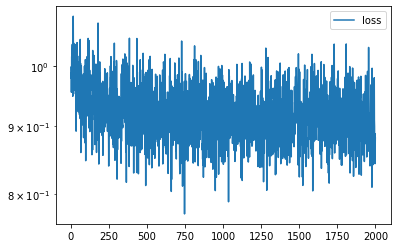

In [30]:
semilogy(np.array(losses[:]), label='loss')
legend()

In [31]:
X = np.arange(-1.5, 2.5, 0.1)
Y = np.arange(-1, 1.5, 0.1)
points = stack(meshgrid(X, Y), axis=-1).reshape((-1, 2))

model_sn = hk.transform_with_state(partial(forward, is_training=False))
score_sn = partial(model_sn.apply, params, state, next(rng_seq))

In [32]:
res, state = score_sn(points, 0.0*jnp.ones((len(points),1)))

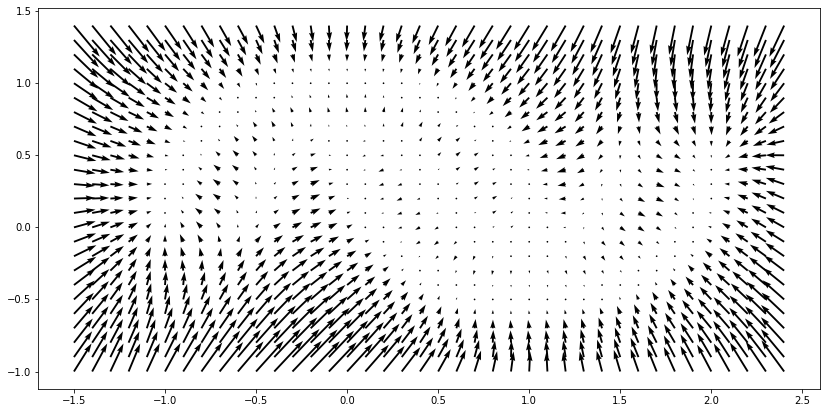

In [33]:
g = res.reshape([len(Y), len(X),2])
figure(figsize=(14,7))
quiver(X, Y, g[:,:,0], g[:,:,1])

/Users/br263581/opt/anaconda3/envs/cosmo/lib/python3.7/site-packages/jax/numpy/lax_numpy.py:1601: FutureWarning: jax.numpy reductions won't accept lists and tuples in future versions, only scalars and ndarrays
  warnings.warn(msg, category=FutureWarning)


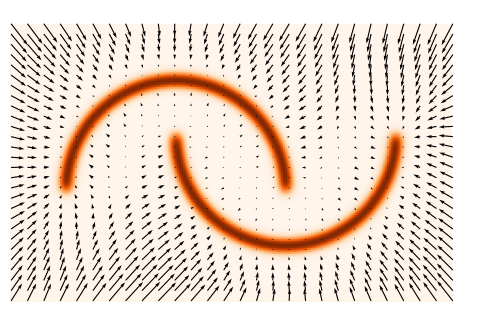

In [34]:
display_score_two_moons(score_sn, two_moons, is_amortized=True, is_reg=True)

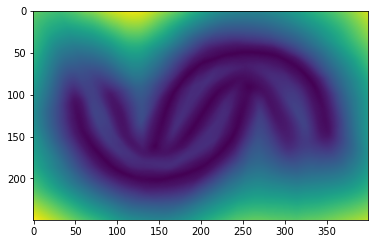

In [35]:
X = np.arange(-1.5, 2.5, 0.01)
Y = np.arange(-1, 1.5, 0.01)
points = stack(meshgrid(X, Y), axis=-1).reshape((-1, 2))
res, state = score_sn(points, jnp.zeros((len(points),1)))
g = res.reshape([len(Y), len(X),2])
imshow(np.sqrt(g[:,:,0]**2 + g[:,:,1]**2))

In [36]:
X = np.arange(-3, 4, 0.2)
Y = np.arange(-2, 3, 0.2)
points = stack(meshgrid(X, Y), axis=-1).reshape((-1, 2))

res, state = score_sn(points, 0.0*jnp.ones((len(points),1)))

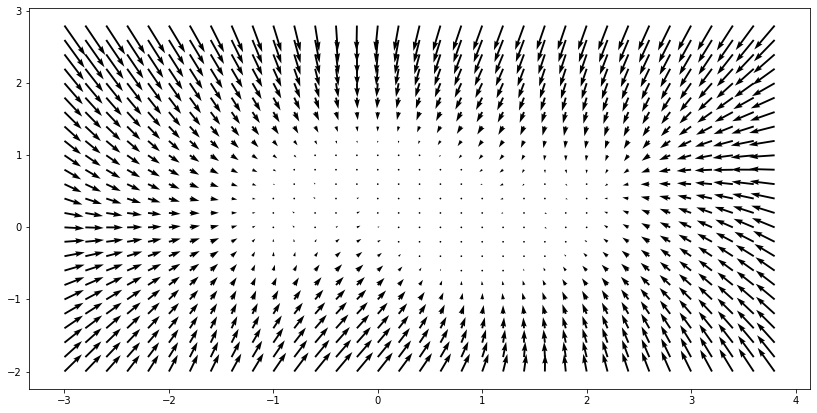

In [37]:
g = res.reshape([len(Y), len(X),2])
figure(figsize=(14,7))
quiver(X, Y, g[:,:,0], g[:,:,1])

In [38]:
def display_score_error_two_moons(true_score, estimated_scores, labels, distribution=None, dpi=100, n=28, is_amortized=True, is_reg=True, scale=1, offset=[0, 0]):
    #plt.figure(dpi=dpi)
    
    #c1 = [-3, -2]
    #c2 = [4, 3]
    scale = scale
    offset = jnp.array(offset)
    
    d_offset = jnp.array([.5, .25])
    c1 = scale * (jnp.array([-.7, -0.5])) + d_offset + offset
    c2 = scale * (jnp.array([.7, 0.5])) + d_offset + offset

    #X = np.arange(c1[0], c2[0], 0.1)
    #Y = np.arange(c1[1], c2[1], 0.1)
    n = 100
    X = np.linspace(c1[0], c2[0], int(n*7/5))
    Y = np.linspace(c1[1], c2[1], n)
    if distribution:
        _x, _y = jnp.meshgrid(jnp.arange(0, len(X), 1), jnp.arange(0, len(Y), 1))
        Z = jnp.stack(jnp.meshgrid(X, Y), axis=-1).reshape((-1, 2))
        S = distribution.log_prob(Z)
        dist = jnp.exp(S.reshape((len(Y), len(X))))
    
    points = stack(meshgrid(X, Y), axis=-1).reshape((-1, 2))
    true_s = true_score(points)
    true_s = true_s.reshape([len(Y), len(X),2])/jnp.linalg.norm(true_s)
    
    n_s = len(scores)
    estimated_vector_fileds = []
    errors = []

    for score in estimated_scores:
        if is_amortized:
            if is_reg:
                estimated_s, state = score(points, 0.0*jnp.ones((len(points),1)))
            else:
                estimated_s = score(points, 0.0*jnp.ones((len(points),1)))
        else:
            if is_reg:
                estimated_s, state = score(points)
            else:
                estimated_s = score(points)
        estimated_s = estimated_s.reshape([len(Y), len(X),2])/jnp.linalg.norm(estimated_s)
        
        estimated_vector_fileds.append(estimated_s)
        errors.append(jnp.linalg.norm(estimated_s - true_s, axis=2))
        
    v_min = jnp.min([jnp.min(e) for e in errors])
    v_max = jnp.max([jnp.max(e) for e in errors])

    for i in range(n_s):
        plt.subplot(n_s, 2, 2*i+1)
        plt.imshow(errors[i], origin='lower', vmin=v_min, vmax=v_max)
        plt.axis('off')
        
        plt.colorbar()
        if distribution:
            plt.contour(_x, _y, dist, levels=[1], colors='white')
        plt.title('Score error ({}), avg={:.2e}'.format(labels[i], jnp.mean(errors[i])), fontsize=9)
        
        plt.subplot(n_s, 2, 2*i+2)
        
        g = estimated_vector_fileds[i]
        plt.quiver(X[::4], Y[::4], g[::4,::4,0], g[::4,::4,1])
        plt.axis('off')
    
    plt.tight_layout()
    plt.savefig('error_comparison.png')    
    

In [39]:
scores = [dae_score, score_sn]
labels = ['DAE', 'SN DAE']

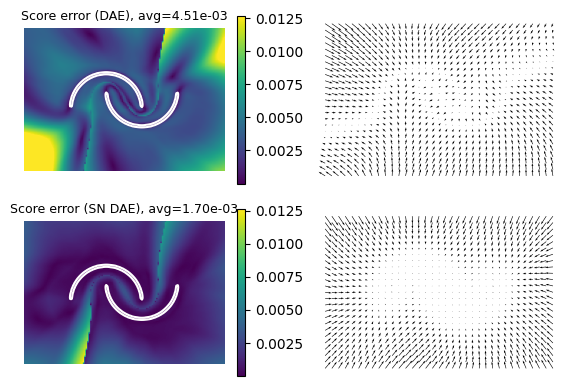

In [40]:
from nsec.utils import display_score_error_two_moons
plt.figure(dpi=100)
scale = 4
offset = [0, 0]
display_score_error_two_moons(true_score, scores, labels, distribution=two_moons, is_amortized=True, is_reg=True, scale=scale, offset=offset)

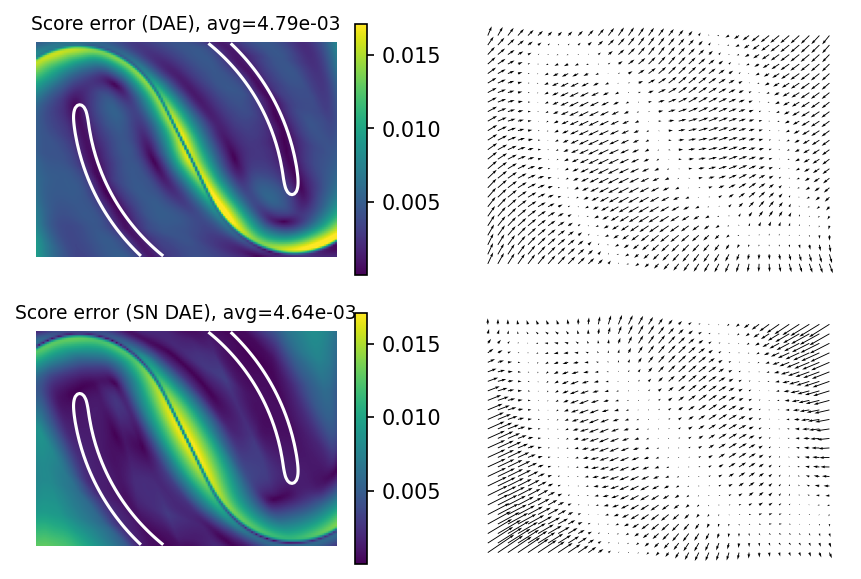

In [41]:
plt.figure(dpi=150)
scale = 1
offset = [0, 0]
display_score_error_two_moons(true_score, scores, labels, distribution=two_moons, is_amortized=True, is_reg=True, scale=scale, offset=offset)
plt.savefig('error_comparison.png')

In [42]:
plt.savefig('error_two_moons_zoomed.png')

<Figure size 432x288 with 0 Axes>

In [43]:
from nsec.models.nflow.nsf import NeuralSplineCoupling, NeuralSplineFlow

In [44]:
def forwardNF(x):
    flow = NeuralSplineFlow()
    return flow(x)
             
model_NF = hk.transform(forwardNF, apply_rng=True)

In [45]:
optimizer = optix.adam(1e-4)
rng_seq = hk.PRNGSequence(42)

In [46]:
batch_size = 512

def make_samples(rng_seq, n_samples, gm):
    return gm.sample(n_samples, seed = next(rng_seq))

distribution = two_moons
def get_batch():
    x = make_samples(rng_seq, batch_size,distribution)
    return {'x': x}

In [47]:
@jax.jit
def loss_fn(params, rng_key, batch):
    log_prob = model_NF.apply(params, rng_key, batch['x'])
    return -jnp.mean(log_prob)

@jax.jit
def update(params, rng_key, opt_state, batch):
    loss, grads = jax.value_and_grad(loss_fn)(params, rng_key, batch)
    updates, new_opt_state = optimizer.update(grads, opt_state)
    new_params = optix.apply_updates(params, updates)
    return loss, new_params, new_opt_state

In [48]:
params = model_NF.init(next(rng_seq), jnp.zeros((1, 2)))
opt_state = optimizer.init(params)

/Users/br263581/opt/anaconda3/envs/cosmo/lib/python3.7/site-packages/jax/lax/lax.py:5946: UserWarning: Explicitly requested dtype <class 'jax.numpy.lax_numpy.int64'> requested in zeros is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/Users/br263581/opt/anaconda3/envs/cosmo/lib/python3.7/site-packages/jax/lax/lax.py:5946: UserWarning: Explicitly requested dtype <class 'jax.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/Users/br263581/opt/anaconda3/envs/co

In [49]:
losses = []
for step in range(2000):
    batch = get_batch()
    loss, params, opt_state = update(params, next(rng_seq), opt_state, batch)
    losses.append(loss)
    if step%100==0:
        print(loss)

2.4737506
1.884132
1.5781745
1.4697741
1.3218837
1.1690726
1.05673
0.84598684
0.7745509
0.666816
0.66688174
0.64261293
0.61867887
0.5407833
0.56385726
0.4995059
0.56904316
0.52711076
0.36571127
0.4602614


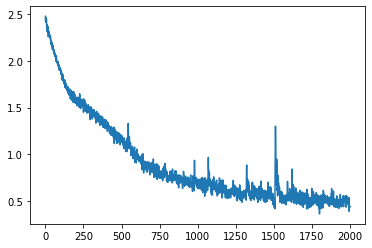

In [50]:
plot(losses)

In [51]:
log_prob = partial(model_NF.apply, params, next(rng_seq))
log_prob(jnp.zeros(2).reshape(1,2)).shape

def log_prob_reshaped(x):
    return jnp.reshape(log_prob(x), ())

score_NF = jax.vmap(jax.grad(log_prob_reshaped))

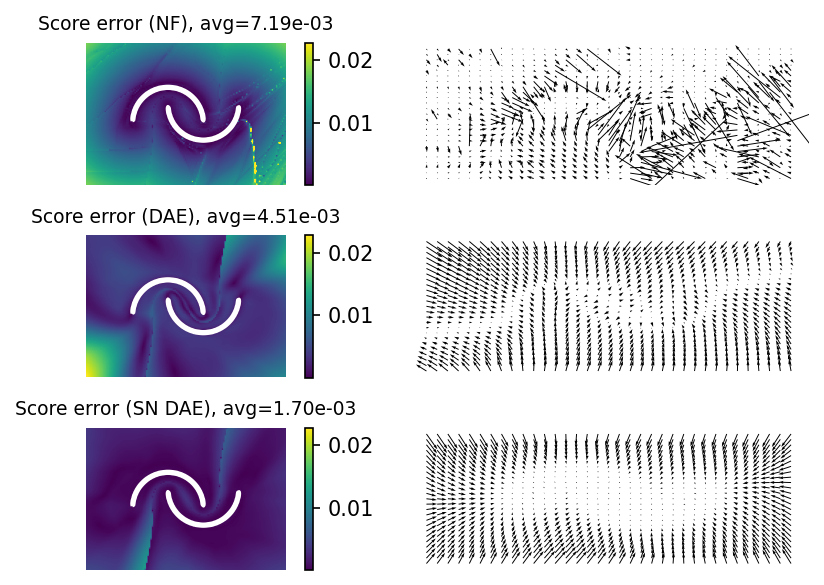

In [53]:
from nsec.utils import display_score_error_two_moons

scores = [score_NF, dae_score, score_sn]
labels = ['NF', 'DAE', 'SN DAE']

plt.figure(dpi=150)
scale = 4
offset = [0, 0]
display_score_error_two_moons(true_score, scores, labels, distribution=two_moons, 
                              is_amortized=True, is_reg=True, scale=scale, offset=offset, is_NF=True)